# Intro to Object Detection Colab

Welcome to the object detection colab!  This demo will take you through the steps of running an "out-of-the-box" detection model on a collection of images.

## Imports and Setup

In [2]:
import os
import pathlib
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

2024-12-10 17:51:20.356094: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 17:51:20.381635: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utilities

In [3]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def get_keypoint_tuples(eval_config):
  """Return a tuple list of keypoint edges from the eval config.
  
  Args:
    eval_config: an eval config containing the keypoint edges
  
  Returns:
    a list of edge tuples, each in the format (start, end)
  """
  tuple_list = []
  kp_list = eval_config.keypoint_edge
  for edge in kp_list:
    tuple_list.append((edge.start, edge.end))
  return tuple_list

### Build a detection model and load pre-trained model weights

This sometimes takes a little while, please be patient!

In [4]:
#pipeline_config = "/home/ttran/projects/TFmodels/models/research/object_detection/colab_tutorials/centernet_hg104_512x512_kpts_coco17_tpu-32/pipeline.config"
pipeline_config = "/home/ttran/projects/TFmodels2/models/research/object_detection/training/ssd_resnet152_v1_fpn_640x640_coco17_tpu-8.config"
model_dir = "/home/ttran/projects/TFmodels2/models/research/object_detection/ssd_resnet152_v1_fpn_640x640_coco17_tpu-8_3"

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-26')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

2024-12-10 17:51:34.197367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-10 17:51:34.198828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-10 17:51:34.219996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Load label map data (for plotting).

Label maps correspond index numbers to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

In [5]:
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

### Putting everything together!

Run the below code which loads an image, runs it through the detection model and visualizes the detection results, including the keypoints.

Note that this will take a long time (several minutes) the first time you run this code due to tf.function's trace-compilation --- on subsequent runs (e.g. on new images), things will be faster.

Here are some simple things to try out if you are curious:
* Try running inference on your own images (local paths work)
* Modify some of the input images and see if detection still works.  Some simple things to try out here (just uncomment the relevant portions of code) include flipping the image horizontally, or converting to grayscale (note that we still expect the input image to have 3 channels).
* Print out `detections['detection_boxes']` and try to match the box locations to the boxes in the image.  Notice that coordinates are given in normalized form (i.e., in the interval [0, 1]).
* Set min_score_thresh to other values (between 0 and 1) to allow more detections in or to filter out more detections.

Note that you can run this cell repeatedly without rerunning earlier cells.


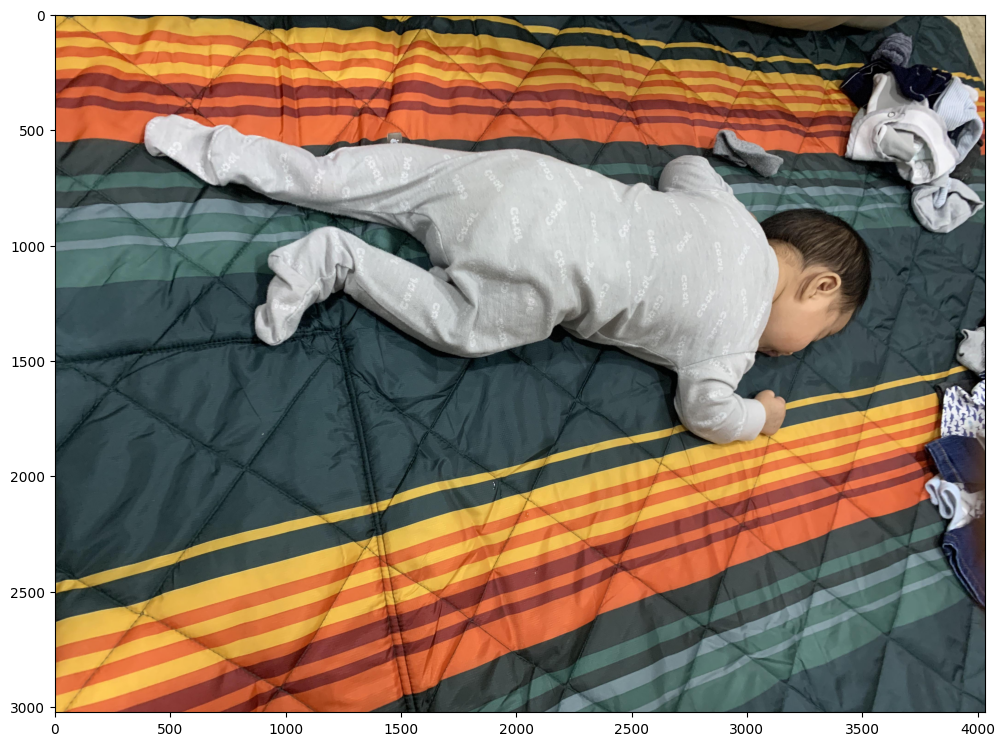

In [ ]:
image_dir = '/home/ttran/projects/TFmodels2/models/research/object_detection/test_images/'
image_path = os.path.join(image_dir, '0a00b11de9ad098befcd6543625b311a9a90ca80.jpg')
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in detections:
  keypoints = detections['detection_keypoints'][0].numpy()
  keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=get_keypoint_tuples(configs['eval_config']))

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

In [11]:
category_index

{1: {'id': 1, 'name': 'mar22'},
 2: {'id': 2, 'name': 'apr22'},
 3: {'id': 3, 'name': 'may22'},
 4: {'id': 4, 'name': 'jun22'},
 5: {'id': 5, 'name': 'jul22'},
 6: {'id': 6, 'name': 'aug22'}}

In [12]:
# Class Prediction
(detections['detection_classes'][0].numpy() + label_id_offset).astype(int)[0]

3

In [13]:
# Certainty
detections['detection_scores'][0].numpy()[0]

0.2593774